# Lab 3: Model selection: dark matter
We'll use the MAGIC telescope dataset (http://www.openml.org/d/1120). The task is to classifying gamma rays, which consist of high-energy particles. When they hit our atmosphere, they produce chain reactions of other particles called 'showers'. However, similar showers are also produced by other particles (hadrons). We want to be able to detect which ones originate from gamma rays and which ones come from background radiation. To do this, the observed shower patterns are observed and converted into 10 numeric features. You need to detect whether these are gamma rays or background radiation. This is a key aspect of research into dark matter, which is believed to generate such gamma rays. If we can detect where they occur, we can build a map of the origins of gamma radiation, and locate where dark matter may occur in the observed universe. However, we'll first need to accurately detect these gamma rays first.

A quick visualization of the features is shown below. Note that this is not a time series, we just plot the instances in the order they occur in the dataset. The first 12500 or so are examples of signal (gamma), the final 6700 or so are background (hadrons).

In [1]:
# General imports
%matplotlib inline
from preamble import *
plt.rcParams['figure.dpi'] = 100

In [2]:
# Download MAGIC Telescope data from OpenML. You can repeat this analysis with any other OpenML classification dataset.
magic = oml.datasets.get_dataset(1120)
X, y, _, _ = magic.get_data(target=magic.default_target_attribute, dataset_format='array'); 
attribute_names = [f.name for i,f in magic.features.items()][:-1][1:]

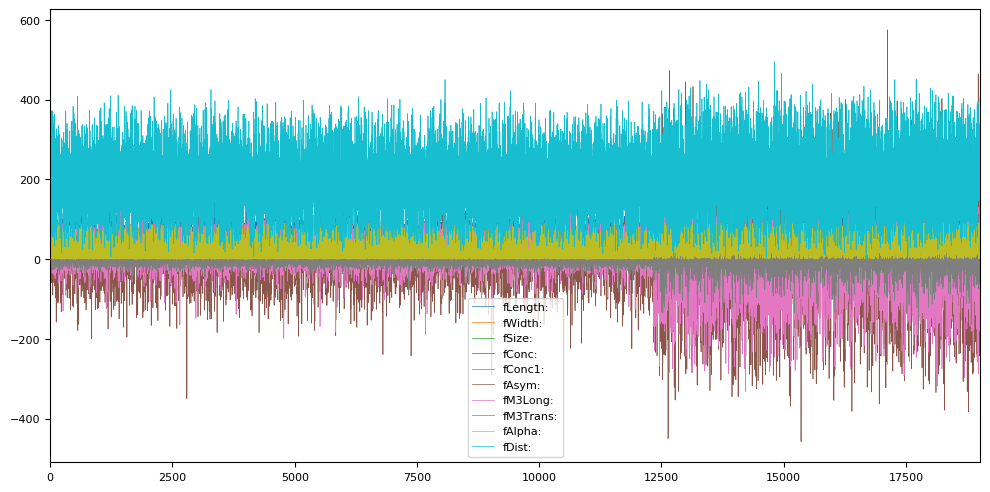

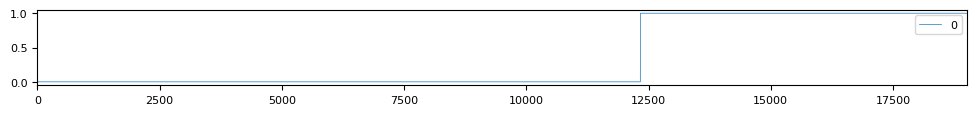

In [3]:
# Quick visualization of the features (top) and the target (bottom)
magic_df = pd.DataFrame(X, columns=attribute_names)
magic_df.plot(figsize=(12,6))
# Also plot the target: 1 = background, 0 = gamma
pd.DataFrame(y).plot(figsize=(12,1));

## Exercise 1: Metrics
Train and evaluate an SVM with RBF kernel (default hyperparameters) using a standard 25% holdout. Report the accuracy, precision, recall, F1 score, and area under the ROC curve (AUC).

Answer the following questions:
* How many of the detected gamma rays are actually real gamma rays?
* How many of all the gamma rays are we detecting?
* How many false positives and false negatives occur?

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.svm import SVC

# Default train-test split
# This is classification, so we definitely want to use stratification again.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=0)

# Train the SVM and retrieve the predictions
svm = SVC().fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [5]:
# Get the scores by comparing the predictions y_pred with the ground truth y_test
print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.3f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.3f}".format(recall_score(y_test, y_pred)))
print("F1 score: {:.3f}".format(f1_score(y_test, y_pred)))
print("AUC: {:.3f}".format(roc_auc_score(y_test, y_pred)))

Accuracy: 0.824
Precision: 0.878
Recall: 0.581
F1 score: 0.700
AUC: 0.769


> How many of the detected gamma rays are actually real gamma rays?

This is precision. Hence, about 88%.

> How many of all the gamma rays are we detecting?

This is recall. Hence, about 58%. That doesn't seem useful at all.

> How many false positives and false negatives occur?

This we can retrieve from the confusion matrix. Remember that in sklearn, the classes are ordered numerically, so the first class is 0 (negative), the second is 1 (positive). That means that the false positives are on row 0, column 1.

In [6]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("There are {} false positives and {} false negatives".format(cm[0,1],cm[1,0]))

There are 135 false positives and 700 false negatives


## Exercise 2: Preprocessing
SVMs require scaling to perform well. For now, use the following code to scale the data (we'll get back to this in the lab about preprocessing and pipelines). Repeat question 2 on the scaled data. Have the results improved? 

In [7]:
from sklearn.preprocessing import StandardScaler
# Important here is to fit the scaler on the training data alone
# Then, use it to scale both the training set and test set
# This assumes that you named your training set X_train. Adapt if needed.
scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test = scaler.transform(X_test)

In [8]:
# Train the SVM and retrieve the predictions
svm = SVC().fit(Xs_train, y_train)
y_pred = svm.predict(Xs_test)

# Get the scores by comparing the predictions y_pred with the ground truth y_test
print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.3f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.3f}".format(recall_score(y_test, y_pred)))
print("F1 score: {:.3f}".format(f1_score(y_test, y_pred)))
print("AUC: {:.3f}".format(roc_auc_score(y_test, y_pred)))

Accuracy: 0.872
Precision: 0.903
Recall: 0.711
F1 score: 0.796
AUC: 0.835


All scores have improved significantly!

## Exercise 3: Hyperparameter optimization
Use 50 iterations of random search to tune the $C$ and $gamma$ hyperparameters on the scaled training data. Vary both on a log scale (e.g. from 2^-12 to 2^12). Optimize on AUC and use 3 cross-validation (CV) folds for the inner CV to estimate performance. For the outer loop, just use the train-test split you used before (hence, no nested CV). Report the best hyperparameters and the corresponding AUC score. Is it better than the default? Finally, use them to evaluate the model on the held-out test set, for all 5 metrics we used before.

Extra challenge: plot the samples used by the random search ($C$ vs $gamma$)

Note: The reason we don't use a nested CV just yet is because we would need to rebuild the scaled training and test set multiple times. This is tedious, unless we use pipelines, which we'll cover in a future lab.

Let's start with the challenge question and plot the set of points selected by randomsearch.
We use a loguniform distribution, which returns values uniformly on a log scale, between 1e-12 and 1e12. To sample randomly from this distibution, we use the random value sample function rvs().

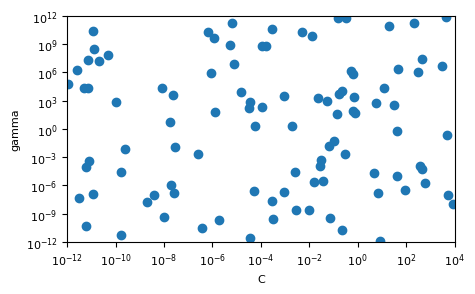

In [9]:
# With scipy 1.4, you can use scipy.stats.loguniform instead
from sklearn.utils.fixes import loguniform

c_samples = loguniform(1e-12, 1e4).rvs(size=100)
g_samples = loguniform(1e-12, 1e12).rvs(size=100)

fig, ax = plt.subplots()
ax.scatter(c_samples,g_samples)
ax.set_xlabel("C")
ax.set_ylabel("gamma")
ax.set_xlim(1e-12, 1e4)
ax.set_ylim(1e-12, 1e12)
ax.set_xscale('log')
ax.set_yscale('log')

In [10]:
from sklearn.model_selection import RandomizedSearchCV
# We use the loguniform distribution
# You could also use a large fixed grid [1e-12, 1e-11,...]
# Large C values slow down training, so we'll limit it to 1e4
param_grid = {'C': loguniform(1e-12, 1e4), 'gamma': loguniform(1e-12, 1e12)}

# Set cv to 3 to do 3-fold CV
# Set scoring to 'roc_auc' to optimize AUC
# Set n_iter to 50 to do 50 iterations
# njobs = -1 allows parallellization
# Optionally, set a verbosity level to see intermediate output 
rs = RandomizedSearchCV(SVC(), param_grid, n_iter=50, cv=3, scoring='roc_auc', verbose=2, n_jobs=-1)
rs.fit(Xs_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.8min finished


RandomizedSearchCV(cv=3, estimator=SVC(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fca10e3ebe0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fca114786d8>},
                   scoring='roc_auc', verbose=2)

In [11]:
print("Best score: {:.4f}",rs.best_score_)
print("Best hyperparameters:", rs.best_params_)

Best score: {:.4f} 0.9101131972886245
Best hyperparameters: {'C': 462.63302228870276, 'gamma': 0.0035856241778658205}


AUC is indeed a lot better than we found before, but note that is the score of the inner CV, not the test set.

Out of interest: are these optimal values close to the defaults we used before? The SVC implementation uses a good heuristic for the defaults: 1 / (n_features * X.var())

In [12]:
print("Default gamma: ",svm._gamma)
print("Default C: ",svm.C)

Default gamma:  0.0999999999483963
Default C:  1.0


Our tuned hyperparameters end up with quite different values.

In [13]:
# Get best estimator, train on the full training set, and evaluate on the test set
best_svm = rs.best_estimator_.fit(Xs_train,y_train)
y_pred = best_svm.predict(Xs_test)

# Get the scores by comparing the predictions y_pred with the ground truth y_test
print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.3f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.3f}".format(recall_score(y_test, y_pred)))
print("F1 score: {:.3f}".format(f1_score(y_test, y_pred)))
print("AUC: {:.3f}".format(roc_auc_score(y_test, y_pred)))

Accuracy: 0.868
Precision: 0.903
Recall: 0.700
F1 score: 0.789
AUC: 0.830


The scores on the test set are slightly lower than we observed before. This likely means that we are overfitting the hyperparameters on the single train test split. Do keep in mind that the result on a single held out test set should be treated with care. It would be best to also do an outer CV to get a better estimate.

## Exercise 4: Threshold calibration
First, plot the Precision-Recall curve for the SVM using the default parameters on the scaled data. Then, calibrate the threshold to find a solution that yields better recall without sacrificing too much precision.

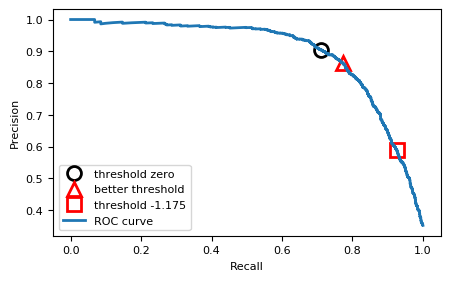

In [14]:
from sklearn.metrics import precision_recall_curve

# Train model
model = SVC().fit(Xs_train,y_train)

# SVC is not probabilistic, so we use the decision function to get the ROC curve
precision, recall, thresholds = precision_recall_curve(y_test, model.decision_function(Xs_test))
# Find threshold closest to 0
close_zero = np.argmin(np.abs(thresholds))
plt.plot(recall[close_zero], precision[close_zero], 'o', markersize=10, label="threshold zero", fillstyle="none", c='k', mew=2)

threshold = -0.28
close_t = np.argmin(np.abs(thresholds-threshold))
plt.plot(recall[close_t], precision[close_t], '^', markersize=10, label="better threshold", fillstyle="none", c='r', mew=2)

threshold = -1.175
close_t = np.argmin(np.abs(thresholds-threshold))
plt.plot(recall[close_t], precision[close_t], 's', markersize=10, label="threshold -1.175", fillstyle="none", c='r', mew=2)

plt.plot(recall, precision, lw=2, label="ROC curve")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend(loc="best");

The Precision-recall curve is really smooth. Every improvement in recall will equally reduce precision. We can move a little bit to the right. There is a small drop around threshold -0.28. That means we will be predicting more points as positive.

## Exercise 5: Cost function
Assume that a false negative is twice as bad (costly) than a false positive. I.e. we would rather waste time checking gamma ray sources that are not real, than missing an interesting gamma ray source. Use ROC analysis to find the optimal threshold under this assumption.

Finally, let the model make predictions using the optimal threshold and report all 5 scores. Is recall better now? Did we lose a lot of precision?

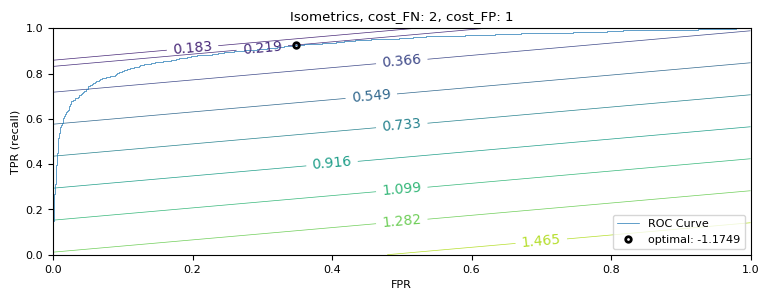

In [15]:
from sklearn.metrics import roc_curve

# Reusing code for the lecture notebook
# Cost function, give the cost for FN and FP
def cost(fpr, tpr, cost_FN, cost_FP, ratio_P):
    return fpr * cost_FP * ratio_P + (1 - tpr) * (1 - ratio_P) * cost_FN;

def plot_isometrics(c_FN=2, c_FP=1):
    # Build the ROC curve for the trained model
    fpr, tpr, thresholds = roc_curve(y_test, model.decision_function(Xs_test))

    # Compute costs
    ratio_P = len(y_test[y_test==1]) / len(y_test)
    costs = [cost(fpr[x],tpr[x],c_FN,c_FP, ratio_P) for x in range(len(thresholds))]
    
    # Get optimal cost and threshold
    min_cost = np.min(costs)
    min_thres = np.argmin(costs)
    min_thres_val = thresholds[np.argmin(costs)]

    # plot contours
    x = np.arange(0.0, 1.1, 0.1)
    y = np.arange(0.0, 1.1, 0.1)
    XX, YY = np.meshgrid(x, y)
    costs = [cost(f, t, c_FN, c_FP, ratio_P) for f, t in zip(XX,YY)]

    # plot all together
    fig, axes = plt.subplots(1, 1, figsize=(9, 3))
    plt.plot(fpr, tpr, label="ROC Curve")
    levels = np.linspace(np.array(costs).min(), np.array(costs).max(), 10)
    levels = np.sort(np.append(levels, min_cost))
    CS = plt.contour(XX, YY, costs, levels)
    plt.clabel(CS, inline=1, fontsize=10)

    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    # find threshold closest to zero:
    plt.plot(fpr[min_thres], tpr[min_thres], 'o', markersize=4,
             label="optimal: {:.4f}".format(min_thres_val), fillstyle="none", c='k', mew=2)
    plt.legend(loc=4);
    plt.title("Isometrics, cost_FN: {}, cost_FP: {}".format(c_FN, c_FP))
    plt.show()
    
plot_isometrics()

Under this cost function, the ideal threshold is -1.175.
Now, let's evaluate what this means for the model's performance.

In [16]:
y_pred = (model.decision_function(Xs_test) >= -1.175).astype(int)

# Get the scores by comparing the predictions y_pred with the ground truth y_test
print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.3f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.3f}".format(recall_score(y_test, y_pred)))
print("F1 score: {:.3f}".format(f1_score(y_test, y_pred)))
print("AUC: {:.3f}".format(roc_auc_score(y_test, y_pred)))

Accuracy: 0.748
Precision: 0.591
Recall: 0.926
F1 score: 0.721
AUC: 0.789


The recall score improved massively (from 71% to 93%), but we also lost a lot of precision (from 90% to 59%). If we plot this threshold in the precision-recall curve (see previous question), we see that it is indeed giving high recall but low precision. Accuracy and AUC also reduced quite a bit. However, if recall is what we really care about, this would still be a good solution.